<a href="https://colab.research.google.com/github/Itsuki-Hamano123/optimizer_prac/blob/master/tsp/verification_quantum_and_googleor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 最適化問題における量子コンピュータと古典コンピュータのアプローチの違い
現状の量子コンピュータと古典コンピュータ、それぞれどんな手順で最適化問題を解き、どんな解が得られるか実験

**去年、ITmediaに、量子コンピュータは巡回セールスマン問題が解けないのかというテーマで２つ記事が掲載されました。**<br>
[ITmedia記事１（https://www.itmedia.co.jp/news/articles/1906/03/news033.html）](https://www.itmedia.co.jp/news/articles/1906/03/news033.html)<br>
[ITmedia記事２（https://www.itmedia.co.jp/news/articles/1911/20/news149.html）](https://www.itmedia.co.jp/news/articles/1911/20/news149.html)<br>
***
2つ目の記事には、「自分の講演では、量子アニーリングで巡回セールスマン問題をやってはダメと伝えている。理由は、組合せ最適化問題の中でも難しい問題で、ガチガチの制約条件を守らないといけないから」という内容がありました。この記事では、主に量子コンピュータのハードから起因したノイズについてメインに語られていました。



一方で現状の量子コンピュータで、最適化問題を扱うためには、QUBO:(Quadratic Unconstrained Binary Optimization)と言われる「制約なし二次形式二値変数最適化」のフレームワークに落とし込まなければいけません。<br>
DeNAで開催された勉強では、**QUBOが起因して巡回セールスマン問題が解けない場合もある**ということを教わりました。<br>
そこで、今回は量子コンピュータハードのノイズでなく、そもそも量子コンピュータで制約条件つきの最適化問題を解く際の手順に着目していきたいと思います。

## 巡回セールスマン問題を解く手順
- **量子コンピュータ**
 1. 目的関数と制約条件を、それぞれQUBO（制約なし二次形式二値変数最適化）行列に落とし込む
 2. ラグランジュ未乗定数（ハイパーパラメータ）を導入し１つの目的関数に結合
 3. 量子コンピュータで、最適化問題用の量子アルゴリズム（量子アニーリングないしはQAOA）を使い解（局所解）を求める
 4. **制約条件が守られるようなラグランジュ未定乗数を見つけるまで２～３を繰り返す**
 ***
- **古典コンピュータ**
 1. 目的関数と制約条件を定義
 2. 制約付き最適化ソルバ（今回は動的計画法）に、目的関数と制約条件をそれぞれ渡し、解（局所解または大域最適解）を求める
 ***
 驚くべきことに、量子コンピュータで制約付き最適化問題を解こうとしたときには、手順2～3を何度も繰り返す必要があり、元の最適化問題を解くためにはラグランジュ未乗定数の最適化も行わないといけないことが分かります。<br>

実際に試してみます。
### 使用するライブラリ
- **座標（グラフ）の生成**
 - NetworkX
- **量子コンピュータ手順で使う**
 - 「PyQUBO」 QUBO行列の整形、量子アニーリング
 （現状の量子コンピュータ実機で、量子アニーリングを行うとハード起因のノイズが発生してしまうので、古典コンピュータ上で量子アニーリングをシュミレートして解を求めます）
  - 「Hyperopt」 ラグランジュ未乗定数に関するベイズ最適化用（古典コンピュータ上で実行）
- **古典コンピュータ手順で使う**
 - 「Google OR-Tools」 巡回セールスマン問題の古典ソルバ


#### ライブラリのインストールと確認

In [1]:
!pip install pyqubo

In [2]:
!python -m pip install --upgrade --user ortools

Requirement already up-to-date: ortools in /root/.local/lib/python3.6/site-packages (7.5.7466)


In [3]:
!pip show pyqubo
!pip show ortools
!pip show networkx

Name: pyqubo
Version: 0.4.0
Summary: PyQUBO allows you to create QUBOs or Ising models from mathematical expressions.
Home-page: https://github.com/recruit-communications/pyqubo
Author: Recruit Communications Co., Ltd.
Author-email: rco_pyqubo@ml.cocorou.jp
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: dimod, dwave-neal, six, numpy
Required-by: 
Name: ortools
Version: 7.5.7466
Summary: Google OR-Tools python libraries and modules
Home-page: https://developers.google.com/optimization/
Author: Google Inc
Author-email: lperron@google.com
License: Apache 2.0
Location: /root/.local/lib/python3.6/site-packages
Requires: six, protobuf
Required-by: 
Name: networkx
Version: 2.4
Summary: Python package for creating and manipulating graphs and networks
Home-page: http://networkx.github.io/
Author: Aric Hagberg
Author-email: hagberg@lanl.gov
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: decorator
Required-by: graph-nets, scikit-image, pyth

### 必要モジュールのimport、定義

In [0]:
# 必要モジュール
from pprint import pprint
import time
import matplotlib.pyplot as plt
import networkx as nx
from ortools.constraint_solver import pywrapcp

In [0]:
def time_watch(func):
    """時間計測用デコレータ関数
    
    Parameters
    -----
    func : function
        実行したい関数

    """
    import functools
    import datetime
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = datetime.datetime.today()
        result = func(*args, **kwargs)
        end = datetime.datetime.today()
        print("実行時間:{time}".format(time=end - start))
        return result
    return wrapper

In [0]:
def explain(item, shows_private=False, shows_method=False):
    """
    与えた python オブジェクトの詳細を表示します。
    
    Notes
    -----
    引用元のサイト:https://qiita.com/halhorn/items/7b8351c5eafbfa28d768
    """
    print('EXPLAIN ------------------')
    print(item)
    print(type(item))
    print('ATTRIBUTES:')
    for d in dir(item):
        if d == 'type':
            continue
        if not shows_private and d.startswith('_'):
            continue
        attr = getattr(item, d)
        if not shows_method and (
                isinstance(attr, types.MethodType) or
                isinstance(attr, types.BuiltinMethodType) or
                isinstance(attr, types.CoroutineType) or
                isinstance(attr, types.FunctionType) or
                isinstance(attr, types.BuiltinFunctionType) or
                isinstance(attr, types.GeneratorType)
        ):
            continue
        print('{}:\t{}'.format(d, attr))

## 座標を定義
最短経路がA→C→D→B→Aとなる以下サイトの4都市を定義<br>[（https://developers.google.com/optimization/routing）](https://developers.google.com/optimization/routing)

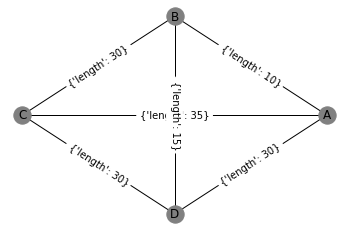

In [26]:
G = nx.Graph()

nodes = ['A','B','C','D']
G.add_nodes_from(nodes)

weight = 'length'
edges = [('A','B',10),('A','C',35),('A','D',30),
         ('B','C',30),('B','D',15),('C','D',30)]
G.add_weighted_edges_from(edges, weight=weight)

# グラフ描画
pos = nx.shell_layout(G)
nx.draw_networkx_edge_labels(G, pos)
nx.draw(G, pos, node_color='grey', with_labels=True)
plt.show()

## （PyQUBOとHyperoptを使い）量子コンピュータで最短経路を求める
ラグランジュ未乗定数の最適化には、ベイズ最適化（古典コンピュータ）を使う


### 問題の定式化
巡回セールスマンの定式化は以下のサイトを参考<br>[(https://quantum.fixstars.com/techresouces/application/traveling-salesman/)](https://quantum.fixstars.com/techresouces/application/traveling-salesman/)
***
**目的関数**<br>
- 最小化したい総経路についての式
 $$L=\frac{1}{2}\sum_{a,i,j}d_{i,j}n_{a,i}(n_{a+1,j}+n_{a-1,j})$$

***
**制約条件**
1. 同時に複数の都市を訪れてはいけない
$$\sum_{i}(\sum_{a}n_{a,i}-1)^2$$
2. 複数回訪れたり、一度も訪れない都市があってはならない
$$\sum_{a}(\sum_{i}n_{a,i}-1)^2$$


### 2つの制約条件を1つの目的関数に結合
結合する際にはラグランジュ未乗定数を使い結合する。以下の式の場合、$k_1$と$k_2$がそれにあたる

#### （ラグランジュ未乗定数を全て1のまま解を求めた場合）

## （Google OR-Toolsを使い）古典コンピュータで最短経路を求める

### 問題を定義

In [0]:
def select_distance_matrix(g, weight):
    """
    距離行列の算出
    
    Parameters
    -----
    g : obj of graph
    weight : string

    Returns
    -----
    distance_matrix : list of list of int
    """
    distance_matrix = []
    nodes = list(g.nodes)
    
    for from_node in nodes:
        distance_list = []
        for to_node in nodes:
            if from_node == to_node:
                distance_list.append(0)
            else: 
                distance_list.append(g[from_node][to_node][weight])
        distance_matrix.append(distance_list)

    return distance_matrix


def definition_data (g, weight, num_vehicles, depot):
    """
    Google OR-Tools用に問題を整形

    Parameters
    -----
    g : obj of graph
    num_vehicles : int
        セールスマンの数
    depot : int
        始点（終点）
    
    Returns
    -----
    data : obj
    """
    data = {}
    data['distance_matrix'] = select_distance_matrix(g, weight)
    data['num_vehicles'] = num_vehicles
    data['depot'] = depot
    return data

In [0]:
data = definition_data(g=G, weight=weight, num_vehicles=1, depot=0)

### ソルバの準備

In [0]:
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

In [0]:
def distance_callback(from_index, to_index):
    """
    2点間の距離を返すコールバック関数
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

In [0]:
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

In [0]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

最適なソルバ発見の戦略設定<br>
（[詳細な公式ドキュメント(https://developers.google.com/optimization/routing/routing_options#first_sol_options)](https://developers.google.com/optimization/routing/routing_options#first_sol_options)

In [0]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()

### 最短経路算出

In [0]:
@time_watch
def solv(routing, search_parameters):
    """
    ソルバで解く
    
    Parameters
    -----
    routing : obj of routing
    search_parameters : obj of search_parameters

    Returns
    -----
    solution : obj of solution
    """
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
      return solution

In [0]:
def print_solution(manager, routing, solution):
  """
  結果を綺麗に描画

  INFO : 公式ドキュメントから抜粋（https://developers.google.com/optimization/routing/tsp）
  """
  print('Objective: {} miles'.format(solution.ObjectiveValue()))
  index = routing.Start(0)
  plan_output = 'Route for vehicle 0:\n'
  route_distance = 0
  while not routing.IsEnd(index):
    plan_output += ' {} ->'.format(manager.IndexToNode(index))
    previous_index = index
    index = solution.Value(routing.NextVar(index))
    route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
  plan_output += ' {}\n'.format(manager.IndexToNode(index))
  print(plan_output)
  plan_output += 'Route distance: {}miles\n'.format(route_distance)

In [104]:
solution = solv(routing=routing, search_parameters=search_parameters)
if solution:
    print_solution(manager, routing, solution)

実行時間:0:00:00.000507
Objective: 90 miles
Route for vehicle 0:
 0 -> 1 -> 3 -> 2 -> 0



### 結果
- 実行時間
 - 0:00:00.000507
- 巡回ルート
 - A → B → D → C → A
- 経路の総距離
 - 90